In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot
import math
import pmdarima as pm
from scipy import stats
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from scipy.special import inv_boxcox
from sklearn.model_selection import ParameterGrid
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from pathlib import Path
monthly_thresholds = {1: [113.20000000000002, 346.6999999999999],
 12: [24.0, 50.89999999999999],
 14: [12.100000000000001, 70.59999999999997],
 22: [20.88134765625, 76.09921875],
 5: [9.0, 25.0],
 16: [281.40000000000003, 445.975],
 23: [14.100000000000001, 32.08281249999999],
 0: [20.0, 61.0]}

def find_state(country_threshold_list, no_cases):
    if no_cases >= float(country_threshold_list[1]):
        return 2
    elif no_cases >= float(country_threshold_list[0]):
        return 1
    else:
        return 0

### Combining Auto Arima with Prophet
Results
1. Auto-Arima achieved 68% accuracy rate when predicting the states of the next two months
2. Combined with prophet, achieves around 67-77% accuracy (best recorded 79% accuracy)

In [16]:
month_data = pd.read_csv('updated_monthly_data.csv', usecols=['Country', 'Date', 'Cases', 'Summary', 'State'], \
                         parse_dates=["Date"])
#set country_index here
country_index = 1
country_monthly_thresholds = monthly_thresholds[country_index]
def compare_predicted_state_to_ground_truth(predicted_no_cases, ground_truth, threshold=country_monthly_thresholds):
    predicted_state = find_state(threshold, predicted_no_cases)
    if predicted_state != ground_truth:
        print("Predicted: {0} Correct: {1}".format(predicted_state, ground_truth))
    return int(predicted_state == ground_truth)
month_data.head()

,Date,Country,Cases,Summary,State
0,2006-01-31,1,833.00000,The districts of Guidan-Roumji in Niger and Do...,2
1,2006-02-28,1,2806.00000,The week 6 was marked by a sudden apparition o...,2
2,2006-03-31,1,6484.00000,Spatial analysis shows an epidemic area common...,2
3,2006-04-30,1,6839.00000,During week 14 it is noted that: Burkina Faso:...,2
4,2006-05-31,1,111.78125,NaN,0


In [17]:
## Testing Autoarima On Monthly Data


def prepare_data_for_model(country_index):
    print(country_index)
    month_data_country = month_data.loc[month_data["Country"] == 1]
    month_data_country = month_data_country.loc[month_data_country["Date"].dt.year >= 2010]
    #Apply Box-Cox transformation to prophet data since that is not gonna go through the pipeline of auto_arima
    month_data_country_prophet = month_data_country.copy()
    
    # X_prophet = month_data_burkina_prophet["Cases"].values
    # X_prophet = stats.boxcox(X_prophet, lmbda=lmbda)
    # prophet fits a more stable model when we plot log(x+1) of the data
    std = month_data_country_prophet["Cases"].std()
    month_data_country_prophet["Cases"] = month_data_country_prophet["Cases"].apply(lambda x: math.log(x+1))
    month_data_country_prophet = month_data_country_prophet.rename(columns={"Date":"ds", "Cases":"y"})
    month_data_country_prophet = month_data_country_prophet.drop(columns=["State", "Country"])

    #Note that we will apply a BoxCox transformation on the data but will integrate it into the pipeline
    X = month_data_country["Cases"].values
    separation_1 = int(len(month_data_country) * 0.6)
    separation_2 = int(len(month_data_country) * 0.8)
    #note must be numpy arrays
    #Below are the arrays we feed into the model
    train_data = X[:separation_1]
    val_data = X[separation_1:separation_2]
    test_data = X[separation_2:]
    
    val_summaries = month_data_country[separation_1:separation_2]["Summary"].values
    val_states = month_data_country[separation_1:separation_2]["State"]
    val_states = val_states.reset_index(drop=True)
    
    test_summaries = month_data_country[separation_2:]["Summary"].values
    test_states = month_data_country[separation_2:]["State"]
    test_states = test_states.reset_index(drop=True)
    country_monthly_thresholds = monthly_thresholds[country_index]
    month_data_country.head()
    return train_data, val_data, val_summaries, val_states, test_data, test_summaries, test_states, country_monthly_thresholds, month_data_country_prophet, separation_1, separation_2
train_data, val_data, val_summaries, val_states, test_data, test_summaries, test_states, country_monthly_thresholds, month_data_country_prophet, separation_val, separation_test = prepare_data_for_model(country_index)


1


In [18]:
class AutoArima():
    def __init__(self):
        #lmbda is the value to add to the training_data to make it non-negative - it's applied manually to the df
        #which will be used by prophet and automatically in the pipeline defined by the Auto-Arima model
        lmbda=1e-6
        self.model = Pipeline([
                        ('boxcox', BoxCoxEndogTransformer(lmbda2=lmbda)),
                        ('arima', pm.AutoARIMA(trace=True,
                                               suppress_warnings=True,
                                               m=12))
                    ])
        
        self.predictions = np.array([])
        self.num_correct = 0
        
        
    def fit(self, train_data):
        self.model.fit(train_data)
        
    def predict(self, test_data, test_states):
        self.num_correct = 0
        self.predictions = np.array([])
        for i in range(0,len(test_data),2):
            preds = self.model.predict(n_periods=2)
            self.predictions = np.append(self.predictions, preds)
            obs = test_data[i:i+2]
            array = list(range(2))
            correct_states_window = test_states.loc[i:i+2].values
            #update pipline so that model predicts from newly observed value
            self.model.update(obs, maxiter=10)
            correct_array = list(map(lambda x: compare_predicted_state_to_ground_truth(preds[x],
                                     correct_states_window[x]), array))
            self.num_correct += sum(correct_array)
            print("")
            print('>Predicted={0}, Expected={1}'.format(preds, obs))
        accuracy = self.num_correct/len(test_data)
        print("Accuracy: %.3f" % accuracy)
        return -mean_absolute_error(test_data, self.predictions)
        
auto_arima = AutoArima()
auto_arima.fit(train_data)
auto_arima.model.summary()
auto_arima.predict(test_data, test_states)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=-6.407, BIC=11.806, Time=0.802 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=57.849, BIC=62.402, Time=0.036 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=-2.072, BIC=7.035, Time=0.651 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=15.761, BIC=24.868, Time=0.119 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=388.239, BIC=390.516, Time=0.007 seconds
Fit ARIMA(2,0,2)x(0,0,1,12) [intercept=True]; AIC=-3.513, BIC=12.424, Time=0.649 seconds
Fit ARIMA(2,0,2)x(1,0,0,12) [intercept=True]; AIC=42.526, BIC=58.463, Time=1.173 seconds
Fit ARIMA(2,0,2)x(2,0,1,12) [intercept=True]; AIC=-4.440, BIC=16.050, Time=1.674 seconds
Fit ARIMA(2,0,2)x(1,0,2,12) [intercept=True]; AIC=-6.287, BIC=14.203, Time=1.383 seconds
Fit ARIMA(2,0,2)x(0,0,0,12) [intercept=True]; AIC=-2.894, BIC=10.766, Time=0.330 seconds
Fit ARIMA(2,0,2)x(0,0,2,12) [intercept=True]; AIC=-4.402, BIC=13.

-59.11469516710577

Test 1: 
Combining Prophet with Auto-Arima by making a proporitional adjustment to auto-arima prediction based on the predictions of prophet

/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to b

          ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
0 2019-11-30  0.000817   12      0    2.659772    4.349870     0.000817   
1 2019-12-31  0.000785   12      0    3.739911    5.438507     0.000785   

   trend_upper  additive_terms  additive_terms_lower  ...   monthly  \
0     0.000817        3.543671              3.543671  ...  3.992013   
1     0.000785        4.591190              4.591190  ...  4.284220   

   monthly_lower  monthly_upper    yearly  yearly_lower  yearly_upper  \
0       3.992013       3.992013 -0.448341     -0.448341     -0.448341   
1       4.284220       4.284220  0.306970      0.306970      0.306970   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  3.544489  
1                         0.0  4.591975  

[2 rows x 21 columns]


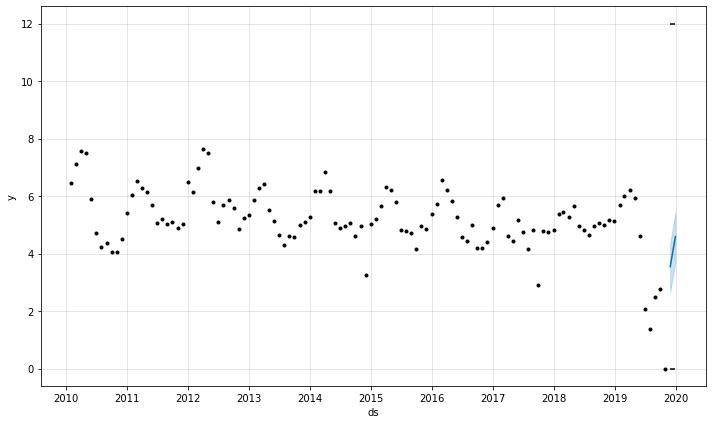

In [455]:
#Before combining Prophet with Auto-Arima, we will see what parameters allow for a good fit on the data
train_prophet = month_data_country_prophet[:-2]
train_prophet["floor"] = 0
train_prophet["cap"] = 12
test_prophet = month_data_country_prophet[-2:]
test_prophet["floor"] = 0
test_prophet["cap"] = 12

model = Prophet(growth = "logistic", seasonality_mode = "additive", weekly_seasonality=False, \
               changepoint_prior_scale=0.3, yearly_seasonality=False).add_seasonality( 
                                                                    name="monthly",
                                                                    period=30.5,
                                                                    fourier_order=3).add_seasonality(
                                                                    name="yearly",
                                                                    period=365.25,
                                                                    fourier_order=10)

test_prophet = test_prophet.drop(columns=["y"])
test_prophet = test_prophet.reset_index(drop=True)
model.fit(train_prophet)
forecast = model.predict(test_prophet)
fig = model.plot(forecast)
print(forecast)

In [19]:
#Keep class definition here until fuly change to modules
from __future__ import unicode_literals, print_function

import plac
import random
import warnings
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding
import os
import operator
import functools

import pandas as pd
import torch
import numpy as np
from datetime import datetime
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import random
import copy
import nltk
from nltk import word_tokenize
# import twint
import spacy
import en_core_web_sm
import geonamescache
from spacy import displacy
from geopy.geocoders import Nominatim
import re
from nltk.corpus import stopwords
import time

from spacy.tokens import Token
from spacy.matcher import Matcher, PhraseMatcher

#this class is used to extract the relevant information for countries mentioned in each report
#for context in terms of order return_sentences_for_countries -> country_short_list -> create_countries_cities_dict
class InformationExtractor():
    def __init__(self, nlp_model):
        self.gc = geonamescache.GeonamesCache() 
        self.all_countries = self.gc.get_countries_by_names()
        self.nlp = spacy.load(nlp_model)
        self.geolocator = Nominatim(user_agent="MenViz")
        #Global variable end_early is to ensure correct identification for AR's of each location
        self.end_early=False
        self.country_list = ['Benin', 'Burkina Faso', 'Burundi', 'Cameroun', 'Centrafrique', "Côte d'Ivoire", 'Ethiopia', 
                'Ghana', 'Guinea', 'Guinea Bissau', 'Gambia', 'Kenya', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 
                'Congo', 'Senegal' , 'South Sudan', 'Sudan', 'Sierra Lone', 
                'Tanzania', 'Chad', 'Togo', 'Uganda']
        self.extensive_country_list = {0: ["Benin", "Bénin"], 1:["Burkina Faso", "Burkina"], 2: ["Burundi"], 3:["Cameroun", 
                          "Cameroon"], 4:["Centrafrique", "Central Africa", "Central African Republuc"], 
                         5: ["Côte d'Ivoire", "Ivory Coast"], 6:["Ethiopia"], 7: ["Ghana"], 8:["Guinea", "Guinée"], 9: 
                         ["Guinea Bissau", "Guinée Bissau"], 10:["Gambia"], 11:["Kenya"], 12: ["Mali"], 13: 
                          ["Mauritania", "Mauritanie"], 14: ["Niger"], 15: ["Nigeria"], 
                          16:["Democratic Republic of Congo", "Congo", "Dem. Rep. Congo"], 17:["Senegal", "Sénégal"], 
                          18:["South Sudan"], 19: ["Sudan"], 20: ["Sierra Lone"], 21: ["Tanzania"], 22: ["Chad", 
                         "Tchad", "Tchad"], 23: ["Togo"], 24: ["Uganda"]}
        #problematic cases to discard after obtaininig named entities
        self.problematic_cases = ["Upper", "Upper East", "Upper West", "East", "Institut Pasteur"]
                         
    #used to check a country and return its corresponding index - do this by looping through the values of the 
    #extensive dictionary list (specifically, loop through all the countries that begin with the same letter) 
    #to reduce computation
    #clean_first is a positional parameter that is used specifically when checking which country a city lies in
    #(i.e. using geopy's diplsay_name)
    def check_if_country(self, country, clean_first=False):
        if clean_first:
            if "Tchad" in country:
                country = "Chad"
        #Côte d'Ivoire will not get recognized for parsing reasons, so we check for it separately
        if "Côte" in country and "Ivoire" in country:
            return self.country_list.index("Côte d'Ivoire")
        #filter countries to only look at ones that start with the same letter
        same_letter_countries = list(filter(lambda x: x.startswith(country[0]), self.country_list))
        for cntry in same_letter_countries:
            if country in self.extensive_country_list[self.country_list.index(cntry)]:
                #return country index (corresponding to position in self.country_list)
                return self.country_list.index(self.extensive_country_list[self.country_list.index(cntry)][0])
        return -1
    #function that will extract the location tags from a given report and return a dictionary of countries as keys
    #and any corresponding cities mentioned as the values
    #note for consistency, the country keys will be represented as ints
    def country_short_list(self, sentences):
        #add a time delay since the geopy API has a low request limit
        time.sleep(0.000000001)
        #array with all cities/countries 
        locations = []
        #dictionary with keys = locations and values = length two array with 0th index start chr and 1st index = end
        chr_loc_segmentations = {}
        doc = self.nlp(sentences)
        #extract any ner tagged with locations and append them to a location array
        ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents if e.label_ in ["GPE", "LOC", "FAC"]]
        for (txt, start_char, end_char, _) in ents:
            #remove brackets since this might be picked by the NER
            if ")" in txt:
                txt = txt.split(")")[0]
            #check problematic cases
            if txt in self.problematic_cases:
                continue
            locations.append(txt)
        #since some of the recognized entities are not recognized by the geocoder, need to put into a format that 
        #it can geocode
#         missing_loc = self.clean_up_cases(locations)
        #remove any duplicates from the list
        locations = list(dict.fromkeys(locations))
#         print(locations)
        countries_cities = self.create_countries_cities_dict(locations)
        return countries_cities
    
    def clean_up_loc(self, loc):
        
        if ";" in loc:
            index = loc.index(";")
            loc = loc[:index]
        if "of" in loc:
            words = loc.split()
            loc = words[-1]
            
        if "Tchad" in loc:
            loc = loc.split("/")[0].strip()
        
        if "Congo" in loc:
            loc = loc[-5:]
            belonging_to_country = self.country_list.index(str(loc))
        elif "Côte d'Ivoire" in loc:
            belonging_to_country = self.country_list.index("Côte d'Ivoire")
        else:
            belonging_to_country = self.country_list.index(str(loc).split(",")[-1].strip())
        return belonging_to_country
    
    #geocode can return an array of possible locations - this function will sift through the options
    #and return any relevant ones - possibile_cities is an array of locations returned from the geocoder and 
    #countries_cities is the dictionary that we will eventually return from this class
    #note since the geolocator may change the spelling of the location after localizing it, and we still need
    #to match the locations to numerical data in the report - we save the original string if the location is found
    def search_array_of_cities(self, possibile_cities, countries_cities, place):
        for city in possibile_cities:
            cntry_code = self.check_if_country(city.raw["display_name"].split(",")[-1].strip(), clean_first=True)
            if cntry_code != -1:
                #TODO: add code to extract the boundingbox values from the city.raw dictionary
                city_name = city.raw["display_name"].split(",")[0]
                if cntry_code not in countries_cities:
                    countries_cities[cntry_code] = [place]
                else:
                    #avoid accidental repetitions of the same location
                    if place not in countries_cities[cntry_code]:
                        countries_cities[cntry_code].append(place) 
                #found a match thus we don't need to search through the rest of the results
                break
    
    #as input takes array of countries/cities and returns a dictionary with countries as keys and cities as values
    def create_countries_cities_dict(self, locations):
        #dictionary with countries as keys and cities mentioned as values
        countries_cities = {}
        #need to look at all possible country options from the dictionary since geocoder will not be able to 
        #process it otherwise
        for place in locations:
            cntry_code = self.check_if_country(place)
            
            if cntry_code != -1:
                if cntry_code not in countries_cities:
                    #store the country as its corresponding int key from self.country_list array
                    countries_cities[cntry_code] = []
            elif place != None:
                loc = None
                try:
                    #the place must be a city thus we need to find which country this city is located in
                    locs = self.geolocator.geocode(place.strip(), exactly_one=False)
                    self.search_array_of_cities(locs, countries_cities, place)
                except Exception as e:
                    pass
        return countries_cities
    
    #return sentence containing specific substring from a report
    #will be used by passing in locations that are present (countries or cities) and returning the string associated 
    #with them - will
    def extract_sentence_given_substring(self, substring, report):
        return re.findall(r""+substring+"(?:[^\.]|\.(?=\d))*[\;).]", report)
        
    
    #given input a report, the function will computea dictionary with countries as keys and cities as values 
    #- this function will return a dictionary with countries as keys and an array of sentences that 
    #contain each of the country/city mentions in the report
    def return_sentences_for_countries(self, report):
        countries_data_dict = {}
        location_dict = self.country_short_list(report)
        for (country, cities) in location_dict.items():
            data_array = []
            #check if cities is empty
            if cities:
                for city in cities:
                    data_array.append((city, self.extract_sentence_given_substring(city, report)))
            else:
                data_array.append((country, self.extract_sentence_given_substring(self.country_list[country], report)))
            countries_data_dict[country] = data_array
        return countries_data_dict
    
    ###### CODE FROM HERE IS FOR EXTRACTING AR/CASES FROM CHOSEN SENTENCES
    
    def dynamically_find_ar(self, doc, start_chr, end_chr, location):
        #for sentences that contain multiple locations NOT separated by periods - need to check in a window ahead
        #if any new locations are being mentioned - we check ahead for any GPE tags
        look_ahead_entities = [e.label_ for e in doc[end_chr:end_chr+10].ents]
        if "GPE" in look_ahead_entities:
            self.end_early=True
        move_fwd = start_chr
        found = False
        #loop through until we either reach end of phrase or we find the atttack rate
        while not found and move_fwd < len(doc):
            move_fwd += 1
            try:
                if type(float(doc[move_fwd].text)) == float:
                    return doc[move_fwd]
            except Exception:
                pass
    
    def process_matches(self, string_id, start_chr, doc, location, end_chr):
        value = None
        if string_id == "cases":
            value = doc[start_chr - 1]
        elif string_id == "AR":
            value = self.dynamically_find_ar(doc, start_chr, end_chr, location, )
        elif string_id == "attack rate":
            value = doc[start_chr + 3]
        
        try:
            value = float(value.text)
        except Exception as e:
            return None
        return value 
    
    def set_up_matcher(self):
        matcher = Matcher(self.nlp.vocab)
        
        ar_patterns_v1 = [{"LOWER": "attack"}, {"LOWER": "rate"}]
        ar_patterns_v2 = [{"LOWER": "ar"}]

        cases_patterns_v1 = [{"TEXT": {"REGEX": "(case[s])"}}]
        
        matcher.add("AR", None, ar_patterns_v1)
        matcher.add("AR", None, ar_patterns_v2)
        matcher.add("cases", None, cases_patterns_v1)
        return matcher
    
    def find_match(self, matcher, sentence, city):
        
        doc = self.nlp(sentence)
        matches = matcher(doc)
        info = {}
        #due to output of regex statement, relevant location will be the first item in the doc
        #check second item to see if it's a number (e.g. in case of list of city, ar where keywords attack rate/cases
        #is not mentioned)
        try:
            if type(float(doc[1].text)) == float:
                info["AR"] = float(doc[1].text)
        except Exception:
            for match_id, start, end in matches:
                location = city
                #check if city is a number => location is a country, and we need to parse it as such
                if type(city) == int:
                    location = self.country_list[city]
                #check we've matched with the noun representing the city
                string_id = self.nlp.vocab.strings[match_id]
                value = self.process_matches(string_id, start, doc, location, end)
                info[string_id] = value
                #Recall, we match with Regex - therefore LOC (location of interest) will always be at the start of the 
                #phrase, however there may be other locations in the same sentence if it was not cuttoff properly
                #e.g. due to missing punctuation marks etc. - if end_early is True, allows us to capture correct
                #metrics for each location and waste unnecessary computation
                if self.end_early:
                    self.end_early=False
                    break
        return info
    

    #function takes as a parameter a dictionary with keys as countries and values tuples containing (city, sentence)
    #return a dictionay with countries as keys and values as tuples containing (city, AR)
    def find_city_ars(self, countries_data_dict):
        matcher = self.set_up_matcher()
        #data dictionary contains countries as keys and values that are arrays of tuples (city, AR)
        data_dict = {}
        for (country, cities) in countries_data_dict.items():
            data_dict[country] = []
            for (city, sentence) in cities:
                if len(sentence) > 0:
                    determined_ar = self.find_match(matcher, sentence[0], city)
                    if determined_ar != {}:
#                         TODO: fix multiple occurnces of same country within paragraph
                        if country in data_dict:
                            data_dict[country].append((city, determined_ar))
                        else:
                            data_dict[country] = [(city, determined_ar)]
        return data_dict


    #call this function to given a summary, give necessary info for the forecasting pipeline
    def symbolically_process_summary(self, summary):
        return self.find_city_ars(self.return_sentences_for_countries(summary))
    


In [20]:
#A class that will be used to apply statistical significance test at each iteration
#QUESTION: what significance level should the p-value be compared to? Can we make this a learnable parameter?
#Main issue: running this pipeline in parallel with some significance level alpha for our different data streams
#means a false alarm in at least one will be much higher than alpha
class SignificanceTest():
    def __init__(self):
        pass
    
    #previous cases will be the array with the number of cases from previous timesteps
    def calculate_probability_distribution(self, previous_cases):
        sum_cases = sum(previous_cases)
        prob_distribution = previous_cases/sum_cases
        return prob_distribution
    
    #recorded_no_cases is the no_cases at the last most availabe timestep and what the significance level will 
    #determine constitutes a suscpicious peak or not
    #bins has to be quite large since we are going to need to calculate the area thus will increase precision
    def calculate_pvalue(self, prob_distribution, beta=100):
        n, bins, patches = plt.hist(prob_distribution, 
                            bins=beta, 
                            density=True)
        recorded_no_cases = prob_distribution[-1]
        #get bin width
        bin_width = bins[1] - bins[0]
        #the code below will find the index of the first bin value > recorded number of cases
        bin1 = np.searchsorted(bins,recorded_no_cases)
        # sum over number in each bin and mult by bin width, which can be factored out    
        integral = bin_width * sum(n[bin1:])
        return integral
    
    def return_pvalue(self, previous_cases, beta=100):
        prob_distribution = self.calculate_probability_distribution(previous_cases)
        return self.calculate_pvalue(prob_distribution, beta)
    
    #compute an exponentially weighted moving average without a bias correction (since we want to dampen the ewma
    #to not add too large of an adjustment)
    def ewma(self, sequence, beta):
        y_current=(beta*sequence[0])
        for i in range(1, len(sequence)):
            y_current = ((beta*y_current) + (1-beta)*sequence[i])
        return y_current


In [21]:
#a class to handle prophet predicting and fitting which will be used in conjunction with auto_arima
class ProphetTimeStep():
    def __init__(self):
        self.model = None
        self.optimum_parameters = None
    
    #TODO: add features to customize prophet model instantiated
    def instantiate_model(self, growth, seasonality_mode, changepoint_prior_scale, n_changepoints):
        self.model = Prophet(daily_seasonality=False,
                             growth=growth,
                             seasonality_mode=seasonality_mode,
                             changepoint_prior_scale=changepoint_prior_scale).\
                             add_seasonality(name="monthly", period=30.5, fourier_order=3)
                                                                    
    #positional parameters have been changed to the optimum ones found from grid search
    def fit_model(self, df, growth="linear", seasonality_mode="additive", changepoint_prior_scale=0.1,
                         n_changepoints=10):
        model = self.instantiate_model(growth, seasonality_mode, changepoint_prior_scale, n_changepoints)
        self.model.fit(df)
    
    def predict_prophet(self, df, counter):
        df = df[:counter]
        self.fit_model(df)

        future = self.model.make_future_dataframe(2, freq="M")
        forecast = self.model.predict(future)
        #need to inverse the log(x+1) transformation that was applied
        inverse_yhat = forecast["yhat"].apply(lambda x: np.exp(x) + 1)
        inverse_yhat_lower = forecast["yhat_lower"].apply(lambda x: np.exp(x)+1)
        inverse_yhat_upper = forecast["yhat_upper"].apply(lambda x: np.exp(x) + 1)
        forecast["yhat"], forecast["yhat_lower"], forecast["yhat_upper"] = inverse_yhat, inverse_yhat_lower,\
                                                                           inverse_yhat_upper
        return forecast[counter:]
    
    def cross_validate_prophet(self, df):
        df_cv = cross_validation(model, initial="3650 days", period="700 days", horizon="700 days")
        return df_cv
    
    #Note the error terms generated from this are on the log(data) which is why the errors are comparatively 
    #small in magnitude
    def find_optimum_hyperparameters(self):
        params_grid = {'seasonality_mode':('multiplicative','additive'),
                       'changepoint_prior_scale':[0.1,0.3,0.5],
                       'n_changepoints' : [10,20]}
        
        
        grid = ParameterGrid(params_grid)
        model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])
        for p in grid:
            self.fit_model(month_data_burkina_prophet[:separation], seasonality_mode=p['seasonality_mode'])
            df_cv = cross_validation(self.model, initial="1461", period="700 days", horizon="365 days")
            #set rolling window=1 to get only one value for each metric rather than one for each horizon length
            mae = performance_metrics(df_cv, rolling_window=1)["mae"].item()
            print(mae)
            model_parameters = model_parameters.append({'MAE':mae, 'Parameters':p}, ignore_index=True)
        parameters = model_parameters.sort_values(by=['MAE'])
        parameters = parameters.reset_index(drop=True)
        self.optimum_parameters = parameters.loc[0, "Parameters"]
        print('OPTIMUM: ', self.optimum_parameters)
            


In [ ]:
test = ProphetTimeStep()
test.find_optimum_hyperparameters()

In [ ]:
class ForecastingPipeline():
    def __init__(self, auto_arima):
        self.gamma = 0
        #significance level/threshold to compare pvalue of suspicious peaks to
        self.alpha = 0.3
        #represents the last n terms that we will use to compute an ewma when determining suspicious peaks
        self.delta = 8
        #represents beta in ewma - will determine the size of the moving window average we determine
        #for now, size of window =1/(1-0.6) which is 2.5
        self.beta = 0.9
        #represents the step taken towards exwa value
        self.mu = 1.5
        #represents multiplier to take step based on nlp information
        self.theta = 0.3
        self.prophet_model = ProphetTimeStep()
        self.stat_sig_test = SignificanceTest()
        self.auto_arima = auto_arima
        self.predictions = np.array([])
        self.num_correct = 0
        self.information_extractor = InformationExtractor(Path("Text Information Extraction/NER_model/"))
    
    #adjusts auto_arima prediction by making a proportional step in direction of prophet_pred and evaluates pvalue
    #size of step depends on confidence interval of prophet - if prophet is very confident of a prediction (meaning 
    #the gap between yhat_lower/upper is quite small), then a large is step is taken and vice versa    
    def make_adjustment(self, prophet_preds, auto_arima_pred, pvalue, sequence, nlp_multipliers):
        #inverse the log(x+1) initally applied on the data
        sequence = list(map(lambda x: np.exp(x) + 1, sequence))
        print(sequence)
        #compute exponential moving average over last handful of terms to capture rate of change (potentially result
        #or build up of a suscpicious spike)
        exma_seq = self.stat_sig_test.ewma(sequence, self.beta)
        print("p-value: {0} adjustment: {1}".format(pvalue, exma_seq))
        rate_to_increment = self.mu*(1 - pvalue) if pvalue < self.alpha else 1/6
        for i in range(len(prophet_preds)):
            proportion = self.gamma/(prophet_preds.iloc[i]["yhat_upper"]-prophet_preds.iloc[i]["yhat_lower"])
            prophet_pred = prophet_preds.iloc[i]["yhat"]
            difference = prophet_pred - auto_arima_pred[i]
            auto_arima_pred[i] += (rate_to_increment*exma_seq) + (self.theta*nlp_multipliers[i]) + difference*proportion 
#             auto_arima_pred[i] = (2/3)*(auto_arima_pred[i]) + (1/6)*prophet_pred + rate_to_increment*exma_seq
        return auto_arima_pred
    #given a summary, this method will extract the relevant nlp details (city and ar) and return an adjustment
    #based on the number of cities in alert and their corresponding attack rate
    def return_nlp_ar_multiplier(self, summary):
        country_city_ars = self.information_extractor.symbolically_process_summary(summary)
        #need to extract nlp details for relevant country we are predicting for
        if country_index in country_city_ars:
            cities = self.information_extractor.symbolically_process_summary(summary)[country_index]
            multiplier = 1
            #check to make sure it's not empty
            if country_city_ars:
                print(country_city_ars)
                for (city, dict_info) in cities:
                    if dict_info["AR"]:
                        multiplier *= dict_info["AR"] 
                return multiplier
        return 0
    
    #will calculate and return multipliers in waves of 2
    def process_summaries(self, summaries):
        multipliers = [0, 0]
        for i in range(0, 2):
            summary = summaries[i]
            #check if summary is nan by seeing if it's equal to itself
            if summary == summary:
                multipliers.append(self.return_nlp_ar_multiplier(summary))
        print(multipliers)
        return multipliers
    
    #predict in waves of 2 e.g. predict at timestep t, t+1,  then update data to from the newly observed values
    # (i.e. actual ground truth labels at previous 4 timesteps) predict at t+2, t+3 and so on

    #Before we output our final prediction, we will make a step that is inversely proportional to yhat_upper -  
    #yhat_lower confidence interval provided by the prophet model. This means if prophet outputs a prediction that 
    #it's very confident about (meaning the confidence range is low), we will make a large step in the direction of 
    #yhat
    def fit_and_predict(self, test_data, month_data_prophet, test_states, test_summaries, separation):
        self.num_correct = 0
        self.predictions = np.array([])
        for i in range(0,len(test_data),2):
            prophet_preds = self.prophet_model.predict_prophet(month_data_prophet, separation+i)
            seq_up_to_point = month_data_prophet[:separation+i]["y"].values
            pvalue = self.stat_sig_test.return_pvalue(seq_up_to_point)
            preds = self.auto_arima.model.predict(n_periods=2)
            print(preds)
            nlp_multipliers = self.process_summaries(test_summaries[i:i+2])
            #make a corresponding adjustment
            preds = self.make_adjustment(prophet_preds, preds, pvalue, seq_up_to_point[-self.delta:], nlp_multipliers)
            self.predictions = np.append(self.predictions, preds)
            print("IN CASE: ", i)
            obs = test_data[i:i+2]
            array = list(range(2))
            correct_states_window = test_states.loc[i:i+2].values
            #update pipline so that model predicts from newly observed value
            self.auto_arima.model.update(obs, maxiter=10)
            correct_array = list(map(lambda x: compare_predicted_state_to_ground_truth(preds[x],
                                     correct_states_window[x]), array))
            self.num_correct += sum(correct_array)
            print("")
            print('>Predicted={0}, Expected={1}'.format(preds, obs))
        accuracy = self.num_correct/len(test_data)
        print("Accuracy: %.3f" % accuracy)
        return -mean_absolute_error(test_data, self.predictions)
    
    def return_errors(self, test_data):
        print("MAE: ", mean_absolute_error(test_data, self.predictions))
        print("RMSE: ", np.power(mean_squared_error(test_data, self.predictions), 0.5))
        
    #define function below which will be used by the Bayesian optimization algorithm
    def black_box_function(self, mu, gamma, beta, alpha):
        self.mu = mu
        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha
        return self.fit_and_predict(test_data, month_data_country_prophet)
    
    def find_optimal_parameters(self):
        # Bounded region of parameter space
        pbounds = {'mu': (0, 5), 'gamma': (1, 100), 'beta':(0.1, 0.95), 'alpha':(0, 0.4)}
        optimizer = BayesianOptimization(
            f=self.black_box_function,
            pbounds=pbounds,
            verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=1,
        )
        
        optimizer.maximize(
            init_points=2,
            n_iter=3,
        )
        print(optimizer.max)


pipeline = ForecastingPipeline(auto_arima)
# train_data_states = month_data_burkina[:separation]["State"]
# print(pipeline.information_extractor.symbolically_process_summary(test_summaries[20]))
pipeline.fit_and_predict(test_data, month_data_country_prophet, test_states, test_summaries, separation_test)
# pipeline.find_optimal_parameters()
# print("\n\n"+ test_summaries[1])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[70.69287156 74.84372749]
{7: [('Bongo', {'AR': 5.4}), ('Builsa', {'AR': 3.2}), ('Nadowli', {'AR': 4.2}), ('Jirapa', {'AR': 8.8}), ('Daffiama', {'AR': 10.6}), ('Lambussie', {'AR': 6.7})], 23: [('Kara', {'AR': 3.7})], 1: [('North', {'AR': 3.2}), ('Zabré', {'AR': 3.1})], 8: [('Kaleo', {'AR': 4.2})], 11: [('West', {'AR': 4.2})], 6: [('Bole', {'AR': 3.9})], 15: [('Damaturu', {'AR': 3.1}), ('Yobe', {'AR': 3.1})], 22: [('Keran', {'AR': 3.7})], 3: [(3, {'AR': 4.5})], 0: [('Tanguieta', {'AR': 3.5})], 17: [('Issa', {'AR': 10.6})]}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


{7: [('Bongo', {'AR': 3.3}), ('Lawra', {'AR': 5.6}), ('Nadowli', {'AR': 7.0}), ('Lambussie', {'AR': 3.3}), ('Nandom', {'AR': 3.8}), ('Talensi', {'AR': 3.4}), ('Jirapa', {'AR': 3.9})], 0: [('Tanguieta', {'AR': 3.5}), ('County', {'AR': 18.0})], 3: [(3, {'AR': 3.5})], 5: [('Katiola', {'AR': 3.7})], 15: [('Gonja', {'AR': 11.6}), ('Babura', {'AR': 3.4}), ('Jigawa State', {'AR': 3.4}), ('Birnin', {'AR': 5.8}), ('Magaji', {'AR': 5.8}), ('Kiyaw', {'AR': 5.8}), ('Zamfara State', {'AR': 5.8}), ('Tangaza', {'AR': 4.3}), ('Sokoto', {'AR': 4.3}), ('Jibia', {'AR': 4.1}), ('Kurfi', {'AR': 3.6}), ('Bodinga', {'AR': 5.6}), ('Damaturu', {'AR': 5.3}), ('Zamfara', {'AR': 5.8}), ('Gummi', {'AR': 5.4}), ('Kiyawa', {'AR': 3.1}), ('Zurmi', {'AR': 3.5})], 23: [(23, {'AR': 3.5})], 1: [], 11: [('West', {'AR': 11.6}), ('Eastern', {'AR': 18.0})], 18: [('Torit', {'AR': 18.0})], 6: [('Bole', {'AR': 5.2})], 24: [('West Region', {'AR': 17.0})], 19: [(19, {'AR': 9.3})]}
[0, 0, 9.920000000000002, 1]
[177.99999999999994,

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


{7: [('Nandom', {'AR': 15.2}), ('Talensi', {'AR': 5.4}), ('Daffiama', {'AR': 5.3}), ('Jaman', {'AR': 5.0})], 0: [('Tanguieta', {'AR': 3.5}), ('Atacora', {'AR': 3.5}), ('Toucountouna', {'AR': 4.4})], 14: [('Aguie', {'AR': 4.5}), ('Keita', {'AR': 6.5}), ('Bouza', {'AR': 3.3}), ('Madarounfa', {'AR': 3.5}), ('Balleyara', {'AR': 4.2}), ('Mbanga', {'AR': 4.6}), ('Madaoua', {'AR': 3.7}), ('Tillia', {'AR': 4.1})], 15: [('Batagarawa', {'AR': 3.8}), ('Batsari', {'AR': 5.0}), ('Mashi', {'AR': 4.7}), ('Kaugama', {'AR': 3.9}), ('Mafara', {'AR': 3.2}), ('Shinkafi', {'AR': 6.6}), ('Wamako', {'AR': 3.9}), ('Kebbe', {'AR': 4.5}), ('Babura', {'AR': 16.4}), ('Silame', {'AR': 14.8}), ('Kaura', {'AR': 4.1}), ('Jibia', {'AR': 4.5}), ('Kaita', {'AR': 5.0}), ('Mani', {'AR': 8.3}), ('Yabo', {'AR': 4.9}), ('Aleiro', {'AR': 24.2}), ('Kebbi', {'AR': 24.2}), ('Kankia', {'AR': 3.7}), ('Albasu', {'AR': 6.1})], 1: [('Faso', {'AR': 4.4}), ('Gaoua', {'AR': 3.1}), ('Goundi', {'AR': 3.8}), ('Gayeri', {'AR': 4.1})], 22: [

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


{0: [('Tanguiéta', {'AR': 3.5}), ('Atacora', {'AR': 3.5}), ('Tanguieta', {'AR': 5.8}), ('Cobly', {'AR': 5.1}), ('Doumé', {'AR': 4.0})], 10: [(10, {'AR': 3.5})], 11: [('Western', {'AR': 1.0})], 3: [(3, {'AR': 5.1})], 1: [('Centre', {'AR': 4.1})]}
[0, 0, 0, 4.1]
[18.999999999999996, 120.99999999999997, 116.99999999999999, 123.00000000000003, 221.00000000000009, 237.0000000000001, 196.0, 288.00000000000006]
p-value: 0.320000000000002 adjustment: 111.33597608999999
IN CASE:  4
Predicted: 0 Correct: 1
Predicted: 0 Correct: 1

>Predicted=[68.26593778 66.14359432], Expected=[144. 121.]
[49.79644541 48.38359589]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[0, 0, 0, 0]
[116.99999999999999, 123.00000000000003, 221.00000000000009, 237.0000000000001, 196.0, 288.00000000000006, 145.99999999999997, 123.00000000000003]
p-value: 0.6960784313725479 adjustment: 148.55718687
IN CASE:  6
Predicted: 0 Correct: 1

>Predicted=[74.55597656 73.14312704], Expected=[103. 144.]
[50.76083613 54.69430794]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


{3: [], 7: [], 8: [], 1: []}
[0, 0, 0, 1]
[221.00000000000009, 237.0000000000001, 196.0, 288.00000000000006, 145.99999999999997, 123.00000000000003, 104.99999999999999, 145.99999999999997]
p-value: 0.5961538461538458 adjustment: 182.85408911000007
IN CASE:  8
Predicted: 0 Correct: 1
Predicted: 0 Correct: 1

>Predicted=[81.23651765 85.16998946], Expected=[160. 149.]
[51.22408759 49.56687224]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[0, 0, 0, 0]
[196.0, 288.00000000000006, 145.99999999999997, 123.00000000000003, 104.99999999999999, 145.99999999999997, 162.00000000000003, 150.99999999999997]
p-value: 0.5566037735849071 adjustment: 165.52875796000004
IN CASE:  10
Predicted: 0 Correct: 1
Predicted: 0 Correct: 1

>Predicted=[78.81221392 77.15499857], Expected=[173. 169.]
[52.24028285 50.34399828]
{7: [('Lawra', {'AR': 3.0}), ('Ahafo', {'AR': 3.2}), ('Zabzugu', {'AR': 9.6}), ('Tatale', {'AR': 9.6}), ('Asutifi South', {'AR': 3.1}), ('Ahafo Region', {'AR': 3.2}), ('Nadowli', {'cases': 12.0, 'AR': 16.4}), ('Asutifi North', {'AR': 3.2}), ('Nkoranza North', {'AR': 3.2})], 24: [('West Region', {'AR': 3.0}), ('Eastern Region', {'AR': 9.6}), ('Northern Region', {'AR': 8.2})], 1: [('Hauts', {'AR': 3.5}), ('Faso', {'AR': 3.5}), ('Kaya', {'cases': 16.0, 'AR': 3.8}), ('Goundi', {'cases': 9.0, 'AR': 4.3}), ('Loum', {'AR': 3.7}), ('Diapaga', {'AR': 5.9}), ('Gaoua', {'AR': 3.4})], 12: [('Karangasso', {'AR': 3.5})], 18: [('Brong', {'A

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


{0: [('Tanguieta', {'AR': 3.4}), ('Atacora', {'AR': 3.4}), ('Littoral', {'AR': 6.0}), ('Materi', {'AR': 3.4}), ('Borgu', {'AR': 10.5})], 1: [('Diapaga', {'AR': 3.8}), ('Gaoua', {'AR': 3.0}), ('Goundi', {'AR': 9.5}), ('Centre', {'AR': 4.0}), ('Batie', {'AR': 3.9})], 3: [], 7: [('Zabzugu', {'AR': 9.6}), ('Tatale', {'AR': 9.6}), ('Lawra', {'AR': 7.6}), ('Jirapa', {'AR': 5.7}), ('Nadowli', {'AR': 9.6}), ('Nandom', {'AR': 13.1}), ('Builsa', {'AR': 4.9})], 22: [('Mandoul', {'AR': 9.5}), ('Korbol', {'AR': 4.9}), ('Bedjondo', {'AR': 9.1}), ('Biobe', {'AR': 4.5}), ('Garoua', {'AR': 3.1}), ('Kyabe', {'AR': 3.1})], 6: [('Dano', {'AR': 3.0})], 24: [('Northern Region', {'AR': 9.6}), ('West Region', {'AR': 7.6})], 10: [], 4: [], 15: [('Kebbi', {'AR': 3.1})], 23: [], 14: [], 21: []}
[0, 0, 14856.646630000001, 1689.4799999999998]
[145.99999999999997, 123.00000000000003, 104.99999999999999, 145.99999999999997, 162.00000000000003, 150.99999999999997, 175.0, 171.00000000000006]
p-value: 0.462962962962961

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


{23: [('Kassena', {'AR': 3.3}), ('Kpendjal', {'AR': 14.0})], 1: [('Sahel', {'AR': 9.2}), ('Goundi', {'AR': 8.2}), ('Sebba', {'AR': 9.2}), ('North', {'AR': 3.9}), ('Gaoua', {'AR': 3.7}), ('Centre', {'AR': 5.7}), ('Danyi', {'AR': 4.2})], 3: [], 7: [('Nandom', {'AR': 7.5}), ('Nadowli', {'AR': 6.8})], 22: [('Mandoul', {'AR': 8.2}), ('Bedjondo', {'AR': 3.0}), ('Guera', {'AR': 3.1})], 24: [('West Region', {'AR': 7.5})], 0: [('Tanguieta', {'AR': 4.5}), ('Atacora', {'AR': 4.5})], 10: [], 15: [('Zamfara', {'AR': 4.4}), ('Kebbi', {'AR': 3.2}), ('Ambam', {'AR': 4.2}), ('Health', {'AR': 5.0})], 11: [('West', {'AR': 7.5})], 4: [('Bangui', {'AR': 5.1}), ('Baboua', {'AR': 5.0}), ('Abba', {'AR': 5.0})], 14: [('Malbaza', {'AR': 3.3}), ('Tahoua', {'AR': 3.3})], 19: [(19, {'AR': 3.9, 'cases': 10.0})], 18: [('Baro', {'AR': 3.1})]}
[0, 0, 394692.05422080006, 239761.79660159993]
[104.99999999999999, 145.99999999999997, 162.00000000000003, 150.99999999999997, 175.0, 171.00000000000006, 296.99999999999994, 41

TODO:
1. Build cross-validation in prophet to find best parameters before fitting
2. Create some optimization function for ForecastingPipeline or build a network that finds best hyperparameters (either through grid search or something else)
3. Compute some performance metrics besides classification one we have been using e.g. MSE (mean-squared error), RSME (root mean squared error) and MAPE (mean absolute percentage error)
4. Right now, just making adjustments based on prophet and hypothesis test - experiment with other techniques like weighted average

**********

A quick note on exponentially moving averages, given $y_{t}$, an exponential moving average is defined as :

$y_{t}$ = $\beta$$y_{t-1}$ + (1-$\beta$)$\theta_{t}$

$\beta$ is a hyperparameter which can be interpreted as taking the average of 1/(1-$\beta$) previous timesteps. Therefore the closer $\beta$ is to 1, the more values it averages over, e.g. if $\beta$ = 0.5, then equivalent of taking an exponentially moving average over the two previous timesteps.

In the context of using this to help determine and make predict suspicious peak, using a large value of $\beta$ will mean the reuslt will adapt more slowly, thus if we want to pick up early on a sudden suspicious spike, a smaller $\beta$ will probably be more appropriate. The problem with using a smaller value of $\beta$ however will be our predictions may become more susceptible to outliers/more noisy.

Since we will only be taking a weighted average over the last couple of datapoints (around 3 or 4)- we will apply bias correction to make our estimates more accurate.

*************

Which test metric to use?
1. RMSE will penalize large differences - may be a good way to check whether we predict a spike or not (prefers smaller numbers)
2. MAE (Mean Absolute Error) - also prefers smaller numbers
3. MBE (Mean Bias Error) - similar to MAE but don't have absolute difference thus sign can give us information about whether we over/underestimate 
4. MAPE (Mean Absolute Percentage Error) looks at ratio - may give better holistic idea of how model is performing, especially across different countries which will have varying number of cases e.g. Burkina Faso tends to have a lot while Mauritania tends to have very little. However this also does not perform well when values are close to 0.

Idea: for each component in our forecasting pipeline, can choose to evalute a difference performance metric based on what behavior we desire to obtain from that component. For example, our significance test is designed to detect spikes, thus a good metric to optimize for would be RMSE since we want to reduce error on large spikes. 

Can use MAPE for prophet since we want to capture the seasonal trend and in general make "solid" predictions on year-round data as opposed to only detecting spikes.

In [ ]:
#with nlp
print(len(test_data))
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(pipeline.predictions, label="Predicted")
ax.plot(test_data, label="Observed")
ax.legend()

In [538]:
print(auto_arima.model.predict(n_periods=2))

[307.28093122 432.36039229]


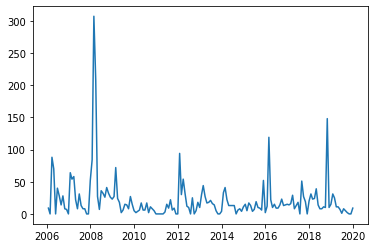

In [57]:
month_data_t = month_data.loc[month_data["Country"] == 5]
plt.plot(month_data_t["Date"].values, month_data_t["Cases"].values)

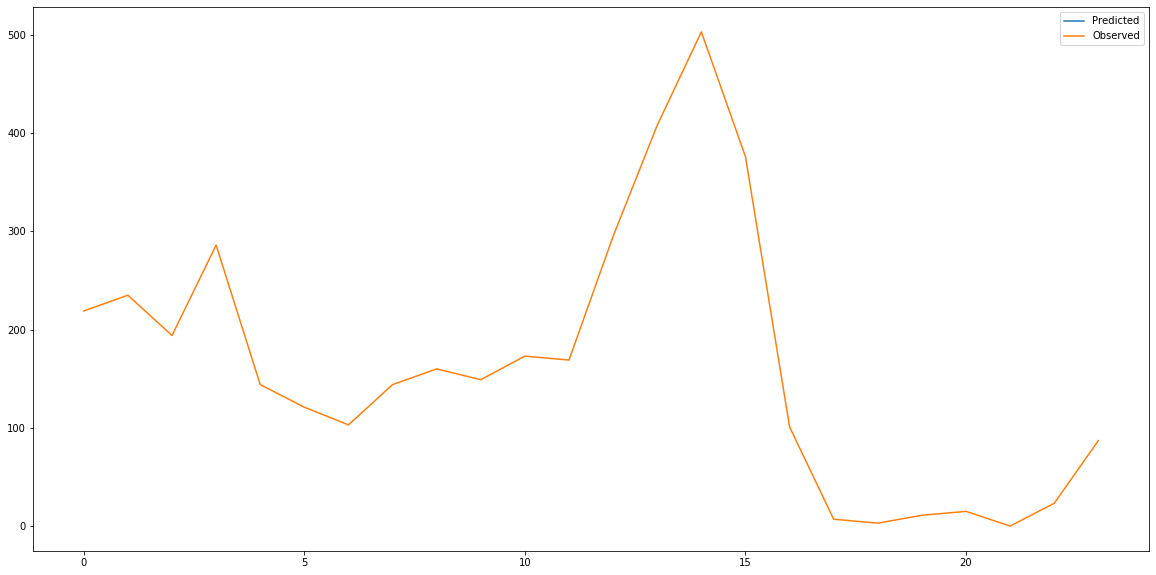

In [559]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(auto_arima.predictions, label="Predicted")
ax.plot(test_data, label="Observed")
ax.legend()

In [551]:
def rsum(arr):
    return rsuma(arr, len(arr)-1)

def rsuma(arr, n):
    if n == 0:
        return arr[0]
    else:
        return arr[n] + rsuma(arr, n-1)
test = [1, 3, 5, 9]
print(rsum(test))

18
